In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import os
import sys
import numpy as np
from scipy import stats

import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('text.latex', preamble=r'\usepackage{amsmath}\usepackage{amssymb}')
import matplotlib.pyplot as plt

old_stdout = sys.__stdout__

In [2]:
# Adapted from
# https://colindcarroll.com/2019/04/11/hamiltonian-monte-carlo-from-scratch/

In [3]:
class Gaussian:
    def __init__(self, mu, Sigma):
        self.mu = np.array(mu)
        self.Sigma = np.array(Sigma)
        self.Lambda = np.linalg.inv(self.Sigma)
        self.K = len(self.mu)
        
    def prob(self, x):
        return np.exp(self.log_prob(x))
        
    def log_prob(self, x):
        shifted_x = x - self.mu
        log_prob = -self.K*np.log(2*np.pi)/2 + np.log(np.linalg.det(self.Lambda))/2 - np.sum(np.matmul(shifted_x, self.Lambda)*shifted_x, -1)/2 
        return log_prob
    
    def score_fun(self, x):
        shifted_x = x - self.mu
        grad = -np.matmul(self.Lambda, np.transpose(shifted_x))
        return np.transpose(grad)
    
class StandardGaussian2D(Gaussian):
    def __init__(self):
        super(StandardGaussian2D, self).__init__([0,0], [[1,0],[0,1]])

# We want to sample from the Gaussian mixture distribution
class GaussianMixture:
    pass

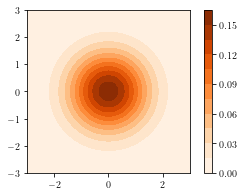

In [4]:
# first visualize the standard Gaussian density

gauss = StandardGaussian2D()

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)
Z = np.stack((X, Y), axis=-1)
prob = gauss.prob(Z)

fig = plt.Figure(figsize=(5, 3))
ax = fig.subplots(nrows=1, ncols=1)
ctf = ax.contourf(X, Y, prob, 10, cmap='Oranges')
fig.colorbar(mappable=ctf, ax=ax)
ax.set_aspect('equal')

fig

In [5]:
# want to sample from the standard Gaussian using score function
# 1. Langevin dynamics
# 2. Hamiltonian Monte Carlo

def langevin_dynamics(score_fun, num_samples=20, ndim=2, step_size=0.1, rng=None):
    # https://abdulfatir.com/blog/2020/Langevin-Monte-Carlo/
    # The blog shows the Langevin dynamics converge to the Gibbs distribution
    if rng is None:
        rng = np.random.RandomState(1234)
        
    samples = []
    x = rng.normal(size=ndim)
    for _ in range(num_samples):
        noise = rng.normal(size=ndim)
        x = x + step_size*score_fun(x) + np.sqrt(2*step_size)*noise
        samples.append(x)
    return np.array(samples)


def hamiltonian_dynamics(score_fun, num_samples=20, ndim=2, step_size=0.1, rng=None):
    if rng is None:
        rng = np.random.RandomState(1234)
        
    samples = []
    q = np.array([1, 1])
    p = np.array([-1, 1])
#     p = np.array([-0.5, 0.5])
    for _ in range(num_samples):
        q = q + step_size*p
        p = p + step_size*score_fun(q)
#         x = x + step_size*score_fun(x) + np.sqrt(2*step_size)*noise
        samples.append(q)
    return np.array(samples)

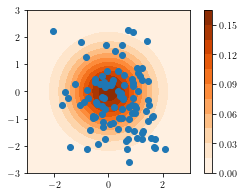

In [6]:
# langevin dynamics
gauss = StandardGaussian2D()

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)
Z = np.stack((X, Y), axis=-1)
prob = gauss.prob(Z)

fig = plt.Figure(figsize=(5, 3))
ax = fig.subplots(nrows=1, ncols=1)
ctf = ax.contourf(X, Y, prob, 10, cmap='Oranges')
fig.colorbar(mappable=ctf, ax=ax)
ax.set_aspect('equal')

samples = langevin_dynamics(gauss.score_fun, num_samples=100, step_size=0.3)

ax.scatter(samples[:,0], samples[:,1])
# ax.plot(samples[:,0], samples[:,1])
fig

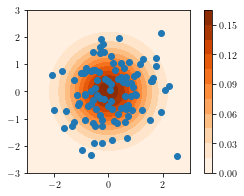

In [7]:
# ground truth samples
x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)
Z = np.stack((X, Y), axis=-1)
prob = gauss.prob(Z)

fig = plt.Figure(figsize=(5, 3))
ax = fig.subplots(nrows=1, ncols=1)
ctf = ax.contourf(X, Y, prob, 10, cmap='Oranges')
fig.colorbar(mappable=ctf, ax=ax)
ax.set_aspect('equal')

samples = np.random.normal(size=(100, 2))
ax.scatter(samples[:,0], samples[:,1])
fig

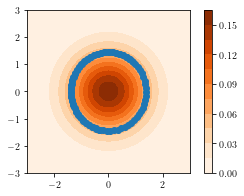

In [9]:
# HMC
gauss = StandardGaussian2D()

x = np.linspace(-3, 3, 100)
y = np.linspace(-3, 3, 100)

X, Y = np.meshgrid(x, y)
Z = np.stack((X, Y), axis=-1)
prob = gauss.prob(Z)

fig = plt.Figure(figsize=(5, 3))
ax = fig.subplots(nrows=1, ncols=1)
ctf = ax.contourf(X, Y, prob, 10, cmap='Oranges')
fig.colorbar(mappable=ctf, ax=ax)
ax.set_aspect('equal')

samples = hamiltonian_dynamics(gauss.score_fun, num_samples=100, step_size=0.1)

ax.scatter(samples[:,0], samples[:,1])
# ax.plot(samples[:,0], samples[:,1])
fig